## Install BART (Should Only Run if you do not have BART)

In [3]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev bc &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

In [4]:
%%bash

BRANCH="master"

cd bart

# Switch to desired branch of the BART project
git checkout -q $BRANCH

# Define specifications
COMPILE_SPECS="PARALLEL=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

## Setup BART Environment (Run every time you start your session)

In [5]:
import os
import sys

# Define environment variables for BART and OpenMP
os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

In [7]:
from google.colab import drive
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
drive.mount('/content/drive')

file_path ='/content/drive/My Drive/BIOE483/brain_rspace.mat'


from bart import bart
from cfl import writecfl,readcfl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Prepare

In [ ]:
# from scipy.io import loadmat
# import matplotlib.pyplot as plt
# import numpy as np
# file_path ='./data/brain_kspace.mat'

# mat_data = loadmat(file_path)

# print("variables:", mat_data.keys())

# image_data = mat_data.get('brain_kspace', None)
# writecfl("./data/brain_kspace",image_data)

## Mat to CFL support function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifft2, ifftshift


def reconstructed_image_func(k_space):
  return np.abs(ifft2(ifftshift(k_space)))

def visualize_kspace_and_image(k_space):
    """
    Visualizes the given k-space data and its reconstructed image.

    Args:
        k_space (numpy.ndarray): 2D complex-valued k-space data.
    """
    # Compute the magnitude of k-space and apply log for visualization
    kspace_magnitude = np.log(np.abs(k_space) + 1e-9)

    # Reconstruct the image using inverse FFT
    reconstructed_image = reconstructed_image_func(k_space)  # Perform inverse FFT and shift to center
    image_magnitude = np.abs(reconstructed_image)  # Take the magnitude for visualization

    # # Calculate PSNR and SSIM
    # psnr_value, ssim_value = evaluate_metrics(image_data, image_magnitude)

    # Plot the k-space magnitude
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(kspace_magnitude, cmap='gray')
    plt.title("k-space (Log Magnitude)")
    plt.colorbar()
    plt.axis("off")

    # Plot the reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(image_magnitude.T, cmap='gray')
    plt.title("Reconstructed Image")
    plt.colorbar()
    plt.axis("off")

    # Show the plots
    plt.tight_layout()
    plt.show()

    # # Print PSNR and SSIM
    # print(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.2f}")


## Make the undersampling data and save to cfl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift

def random_stripe_sampling(shape, center_fraction=0.1, acceleration=4):
    """
    生成模拟 MRI 欠采样的二维掩码，结合中心列完全采样和随机条纹采样。

    参数:
        shape (tuple): 掩码的形状（例如二维图像的 shape，如 (128, 128)）。
        center_fraction (float): 中心列的采样比例 (0 < center_fraction < 1)。
        acceleration (int): 欠采样加速因子，控制整体采样的稀疏性。

    返回:
        np.ndarray: 二维掩码，值为 0 或 1。
    """
    num_rows, num_cols = shape

    # 初始化掩码为全 0
    mask = np.zeros((num_rows, num_cols), dtype=np.float32)

    # 1. 中心列采样
    num_low_freq_cols = int(num_cols * center_fraction)
    start_col = (num_cols - num_low_freq_cols) // 2
    end_col = start_col + num_low_freq_cols
    mask[:, start_col:end_col] = 1  # 对中心列完全采样

    # 2. 随机条纹采样（控制加速因子）
    # 剩余采样列数：确保总采样数符合加速因子要求
    total_samples = int(num_cols / acceleration)
    remaining_samples = max(0, total_samples - num_low_freq_cols)

    # 生成随机条纹索引
    random_cols = np.random.choice(
        [i for i in range(num_cols) if i < start_col or i >= end_col],  # 排除中心列
        size=remaining_samples,
        replace=False
    )

    # 将随机选择的条纹设置为采样
    mask[:, random_cols] = 1

    return mask



In [ ]:
def random_sampling(shape, sampling_ratio):
    """
    生成一个随机采样的二值掩码（Mask）。

    参数：
    - shape: tuple, 掩码的形状（如 (128, 128)）。
    - sampling_ratio: float, 采样率（例如 0.3 表示采样点占 30%）。

    返回：
    - mask: ndarray, 二值掩码，值为 0 或 1。
    """
    # 随机生成 [0, 1) 的均匀分布
    random_matrix = np.random.rand(*shape)

    # 根据采样率生成二值掩码
    mask = (random_matrix < sampling_ratio).astype(np.float32)

    return mask

In [ ]:
k_space = readcfl("./data/brain_kspace")

# Generate a sampling mask
random_stripe_mask = random_stripe_sampling(k_space.shape, center_fraction=0.1, acceleration=3)
random_mask = random_sampling(k_space.shape,0.5)

# Apply the mask to the k-space data
random_stripe_mask_k_space = k_space * random_stripe_mask
random_mask_k_space = k_space * random_mask

writecfl("./data/random_stripe_mask", random_stripe_mask)
writecfl("./data/random_mask", random_mask)
writecfl("./data/random_stripe_mask_k_space", random_stripe_mask_k_space)
writecfl("./data/random_mask_k_space", random_mask_k_space)


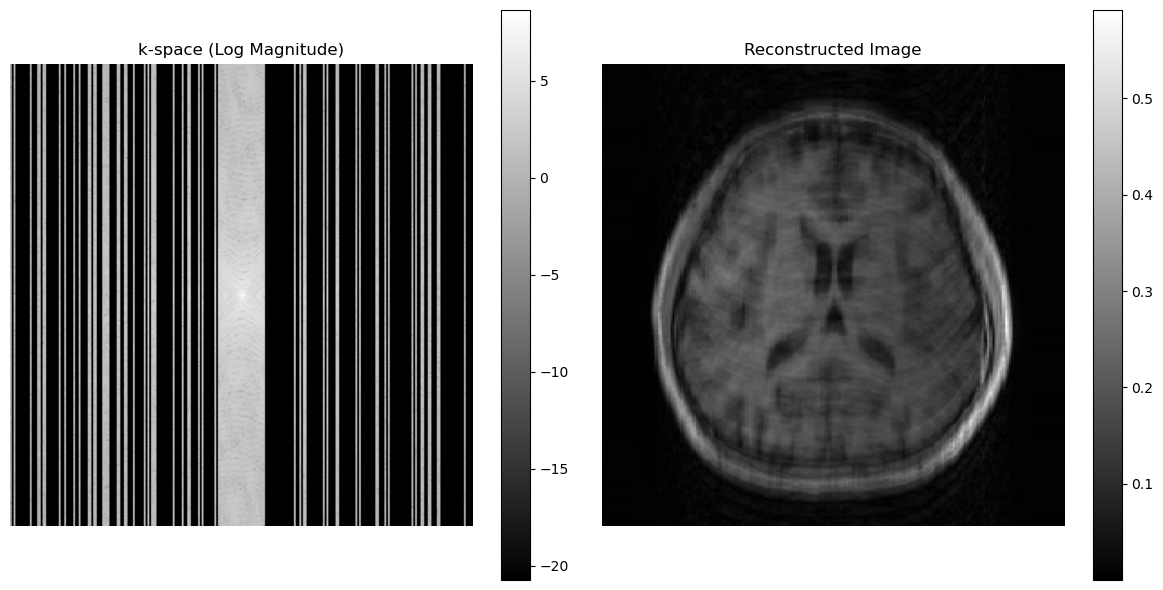

In [ ]:
visualize_kspace_and_image(random_stripe_mask_k_space)

In [ ]:
def display_cfl(file_name, title="BART CFL Image"):
    """
    读取并显示 .cfl 文件的图像。
    :param file_name: 不含扩展名的文件路径
    :param title: 显示图像的标题
    """
    # 读取数据
    data = readcfl(file_name)

    # 显示图像的幅值
    plt.figure(figsize=(6, 6))
    plt.imshow(np.abs(data), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

## Show the full sampling image

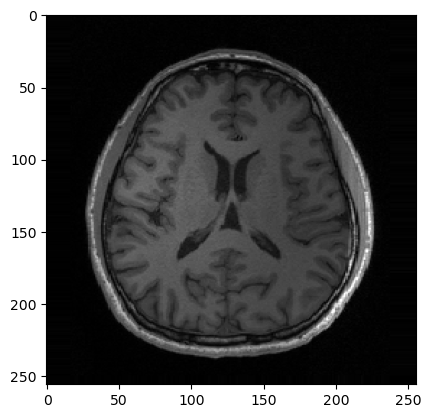

In [ ]:
from numpy.fft import ifft2, fftshift

brain_iamge_full = cfl.readcfl("./data/brain_kspace")

image = ifft2(brain_iamge_full)

plt.imshow(image_magnitude.T, cmap='gray')


## Use bart to reconstruct

In [ ]:
file_path = './data/brain_kspace.mat'

mat_data = loadmat(file_path)

print("variables:", mat_data.keys())

kspace = mat_data.get('brain_kspace', None)

variables: dict_keys(['__header__', '__version__', '__globals__', 'brain_kspace'])


In [ ]:
random_stripe_mask = random_stripe_sampling(k_space.shape, center_fraction=0.1, acceleration=3)
random_stripe_mask_k_space = k_space * random_stripe_mask


In [ ]:
sens_maps = bart(1, "ecalib -d0 -m1", random_stripe_mask_k_space)

Done.


In [ ]:
reg_wt = 0.01
num_iters = 50
pred = bart(
        1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", random_stripe_mask_k_space, sens_maps
    )

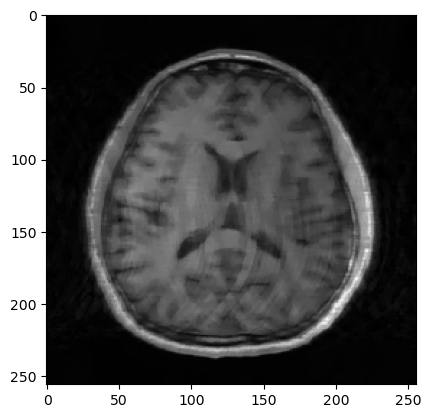

In [ ]:
plt.imshow(np.abs(fftshift(pred)),cmap = "gray")